In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from time import time

from IPython.display import display

np.random.seed(42)
pd.options.display.max_columns = None

In [2]:
X_train = pd.read_csv('../data/processed/X_train.tsv',sep='\t')
X_test = pd.read_csv('../data/processed/X_test.tsv',sep='\t')
y_train = pd.read_csv('../data/processed/y_train.tsv',sep='\t')
y_test = pd.read_csv('../data/processed/y_test.tsv',sep='\t')

In [3]:
X_train.set_index(keys='EmployeeNumber',inplace=True)
X_test.set_index(keys='EmployeeNumber',inplace=True)
y_train.set_index(keys='EmployeeNumber',inplace=True)
y_test.set_index(keys='EmployeeNumber',inplace=True)

# Part 1: Logistic Regression

In [4]:
# Develop param_grid for GridSearch, consisting of different values of C and different penalty types.
# Doesn't seem to be an impetus for trying different solvers.
C_grid = np.append(np.arange(0.1, 1, .1),np.arange(2, 10, 1,dtype=float))
print(C_grid)
param_grid = {'C': C_grid,'penalty':['l1','l2']}
kfold_object = StratifiedKFold(5, shuffle = True, random_state = 42)
logreg_for_grid = LogisticRegression(solver='liblinear')
logreg_cv = GridSearchCV(logreg_for_grid,param_grid,cv=kfold_object)
logreg_cv.fit(X_train,y_train.values.ravel())
y_pred_logreg = logreg_cv.predict(X_test)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 2.  3.  4.  5.  6.  7.  8.  9. ]


In [5]:
print(logreg_cv.best_params_)

{'C': 2.0, 'penalty': 'l2'}


C of 8 was surprising, and when I changed the random state it would fluctuate to other values, including values <1. Unclear why the result for C is so volatile.

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

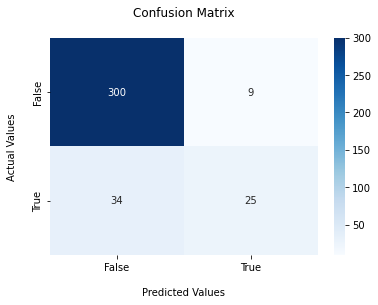

In [6]:
pl = confusion_matrix(y_test,y_pred_logreg)
#As posted by Graham Smith in Slack
ax = sns.heatmap(pl, annot=True, fmt='n',cmap='Blues')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');
## Tick labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [7]:
print(classification_report(y_test,y_pred_logreg))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       309
           1       0.74      0.42      0.54        59

    accuracy                           0.88       368
   macro avg       0.82      0.70      0.74       368
weighted avg       0.87      0.88      0.87       368



Low recall is discouraging, though precision is nice.  Will explore ROC and precision-recall curve to see if different probability thresholds can improve recall while maintaining precision.

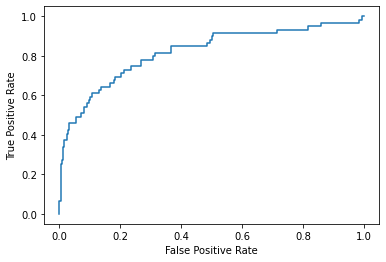

0.8180023037683067


In [8]:
#code informed by https://www.statology.org/plot-roc-curve-python/
y_pred_proba = logreg_cv.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(roc_auc_score(y_test, y_pred_proba))

ROC looks good and shows high AUC

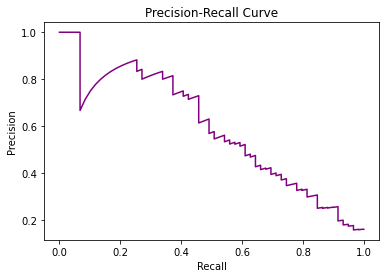

In [9]:
#code informed by https://www.statology.org/precision-recall-curve-python/
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

In [10]:
thresholds = np.arange(0.1,1,.1)
print(thresholds)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


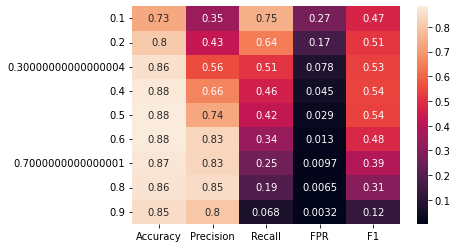

In [11]:
scores = np.zeros([len(thresholds),5])
for i in range(len(thresholds)):
    classified_probas = y_pred_proba > thresholds[i]
    scores[i,0] = accuracy_score(y_test,classified_probas)
    scores[i,1] = precision_score(y_test,classified_probas)
    scores[i,2] = recall_score(y_test,classified_probas)
    cm = confusion_matrix(y_test,classified_probas)
    scores[i,3] = cm[0,1]/(cm[0,1]+cm[0,0])
    scores[i,4] = f1_score(y_test,classified_probas)
scores_df = pd.DataFrame(scores,columns = ['Accuracy','Precision','Recall','FPR','F1'], index = thresholds)
_ = sns.heatmap(scores_df,xticklabels=True,yticklabels=True,annot=True)

As evidenced by the precision-recall curve and the score heatmap above, good recall is only achieved by significantly lowering the classification probability threshold, which doesn't impact the FPR much but does reduce precision.

I also explored introducing class_weights (balanced), and scoring the gridsearch based on f1 and roc_auc but got no improvement in recall without losing significant precision.

In [12]:
selected = logreg_cv.best_estimator_.feature_names_in_
coefs = logreg_cv.best_estimator_.coef_
print(pd.Series(coefs.reshape(-1,), index=selected).sort_values(ascending=False))

OverTime_Yes                         1.989163
BusinessTravel_Travel_Frequently     1.694210
MaritalStatus_Single                 1.302579
TrainingTimesLastYear_None           1.202572
JobRole_Laboratory Technician        1.069893
JobRole_Sales Representative         1.046155
JobRole_Human Resources              0.941939
BusinessTravel_Travel_Rarely         0.721627
NumCompaniesWorked                   0.646588
JobRole_Manager                      0.574003
JobRole_Sales Executive              0.489704
Department_Sales                     0.485268
YearsSinceLastPromotion              0.482714
TrainingTimesLastYear_Four Times     0.464475
DistanceFromHome                     0.425785
YearsAtCompany                       0.389648
Gender_Male                          0.336796
TrainingTimesLastYear_Twice          0.327914
MaritalStatus_Married                0.203221
PerformanceRating                    0.183343
Education_Bachelor                   0.148737
EducationField_Technical Degree   

# Part 2: Random Forest

In [13]:
# Develop param_grid for RandomizedSearch. Informed by
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# In first iteration I ran, I experimented with non-default values for criterion and bootstrap, but the best parameters
# included the default values so I removed those options to create a more focused randomized search

n_estimators_grid = np.arange(200,2000,100)
max_depth_grid = [int(x) for x in np.arange(5, 50, 5)]
max_depth_grid.append(None)
min_samples_split_grid = range(2,10)
min_samples_leaf_grid = range(1,5)

param_grid = {'n_estimators':n_estimators_grid,
              'max_depth':max_depth_grid,
              'min_samples_split':min_samples_split_grid,
              'min_samples_leaf':min_samples_leaf_grid}

kfold_object = StratifiedKFold(5, shuffle = True, random_state = 42)
rf_for_grid = RandomForestClassifier(max_features = 'sqrt',random_state = 42)
rf_random_cv = RandomizedSearchCV(rf_for_grid,param_grid, n_iter = 200, cv = kfold_object, verbose=2, random_state=42, n_jobs = -1)
rf_random_cv.fit(X_train,y_train.values.ravel())
y_pred_rf = rf_random_cv.predict(X_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [14]:
print(rf_random_cv.best_params_)

{'n_estimators': 1300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15}


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

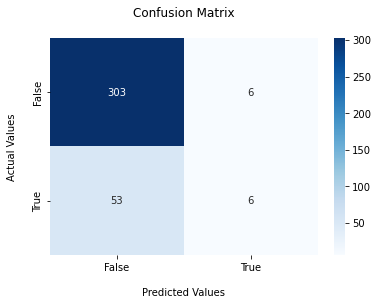

In [15]:
pl = confusion_matrix(y_test,y_pred_rf)

ax = sns.heatmap(pl, annot=True, fmt='n',cmap='Blues')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');
## Tick labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [16]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       309
           1       0.50      0.10      0.17        59

    accuracy                           0.84       368
   macro avg       0.68      0.54      0.54       368
weighted avg       0.79      0.84      0.79       368



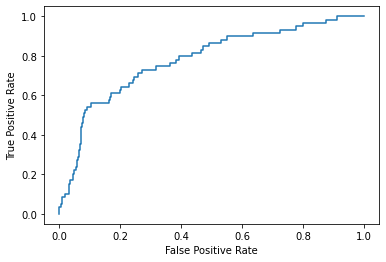

0.7790027974329439


In [17]:
y_pred_proba_rf = rf_random_cv.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_rf)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(roc_auc_score(y_test, y_pred_proba_rf))

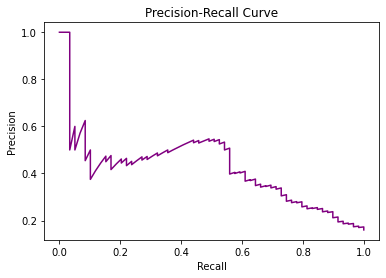

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_rf)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

In [19]:
thresholds = np.arange(0.1,1,.1)
print(thresholds)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


C:\Users\eagra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


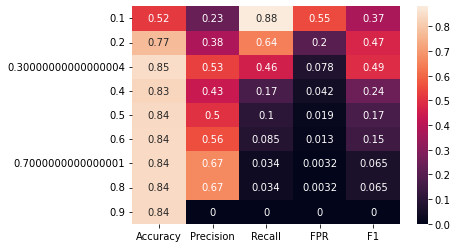

In [20]:
scores = np.zeros([len(thresholds),5])
for i in range(len(thresholds)):
    classified_probas = y_pred_proba_rf > thresholds[i]
    scores[i,0] = accuracy_score(y_test,classified_probas)
    scores[i,1] = precision_score(y_test,classified_probas)
    scores[i,2] = recall_score(y_test,classified_probas)
    cm = confusion_matrix(y_test,classified_probas)
    scores[i,3] = cm[0,1]/(cm[0,1]+cm[0,0])
    scores[i,4] = f1_score(y_test,classified_probas)
scores_df = pd.DataFrame(scores,columns = ['Accuracy','Precision','Recall','FPR','F1'], index = thresholds)
_ = sns.heatmap(scores_df,xticklabels=True,yticklabels=True,annot=True)

Model performs extremely poorly, unclear why. To be discussed.  As I did with the logistic regression, here I also explored using balanced class weights or scoring based on roc_auc and f1 but to no avail.

In [21]:
imps = rf_random_cv.best_estimator_.feature_importances_
print(pd.Series(imps, index=X_train.columns).sort_values(ascending=False))

MonthlyIncome                        0.085067
Age                                  0.075234
TotalWorkingYears                    0.067079
RatioToMedianPay                     0.063707
DistanceFromHome                     0.057031
YearsAtCompany                       0.050138
YearsWithCurrManager                 0.044781
OverTime_Yes                         0.043343
NumCompaniesWorked                   0.042458
PercentSalaryHike                    0.041871
YearsInCurrentRole                   0.032290
JobInvolvement                       0.031983
JobSatisfaction                      0.030639
YearsSinceLastPromotion              0.029219
MaritalStatus_Single                 0.021491
EnvironmentSatisfaction              0.020654
BusinessTravel_Travel_Frequently     0.016225
RelationshipSatisfaction             0.015343
WorkLifeBalance                      0.013600
JobRole_Laboratory Technician        0.013100
Gender_Male                          0.012718
TrainingTimesLastYear_Twice       

# Part 3: Pycaret

In [22]:
combined_train = pd.concat([X_train,y_train],axis=1)
combined_test = pd.concat([X_test,y_test],axis=1)
data_pycaret = pd.concat([combined_train,combined_test])

In [23]:
from pycaret.classification import *
s = setup(data_pycaret,target = 'Attrition',preprocess=False,fold_shuffle=True,data_split_stratify=True,fix_imbalance=True)

,Description,Value
0,session_id,5561
1,Target,Attrition
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1470, 46)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,34
8,Transformed Train Set,"(1028, 45)"
9,Transformed Test Set,"(442, 45)"


In [24]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8890,0.8276,0.4526,0.7862,0.5663,0.5086,0.5384,0.0120
lr,Logistic Regression,0.8852,0.8351,0.3982,0.7941,0.5245,0.4681,0.5068,0.7340
ridge,Ridge Classifier,0.8696,0.0000,0.2540,0.7940,0.3780,0.3290,0.3976,0.0110
gbc,Gradient Boosting Classifier,0.8618,0.8146,0.3081,0.6452,0.4085,0.3442,0.3774,0.0500
catboost,CatBoost Classifier,0.8599,0.8085,0.2114,0.7333,0.3265,0.2744,0.3420,0.8440
ada,Ada Boost Classifier,0.8589,0.7897,0.3423,0.6387,0.4365,0.3648,0.3926,0.1410
et,Extra Trees Classifier,0.8580,0.7922,0.1868,0.7350,0.2953,0.2473,0.3206,0.0680
rf,Random Forest Classifier,0.8521,0.8040,0.1452,0.7133,0.2370,0.1943,0.2706,0.0780
svm,SVM - Linear Kernel,0.8453,0.0000,0.4386,0.5778,0.4686,0.3848,0.4038,0.0130
knn,K Neighbors Classifier,0.8414,0.6580,0.1151,0.5350,0.1868,0.1398,0.1912,0.3400


Linear discriminant analysis and logistic regression have the best results, which are comparable to those from the manual logistic regression from part 1.

In [26]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [27]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

There is decent overlap in feature importance between the LDA model and the manual logistic regression model from part 1, though it appears the feature importance chart here doesn't consider features that are strongly negatively correlated with attrition such as survey response scores (e.g., work-life balance, job involvement).

# Part 4: Analysis of models

Based on the manual models (logistic and random forest) and the more comprehensive pycaret analysis, it appears there is no model that can yield both high recall and high precision.  I believe this is a product of attrition being potentially driven by many factors, including factors beyond the information available in the database.

For example, high performers may not have anything particularly negative to say in employee surveys, may not be in a department with particularly high turnover, may be paid well, etc. but could be poached for a better opportunity nonetheless.  Life events such as relocation, career shifts, going back to school, etc. may drive attrition but not be reflected in the available data (except in a correlative capacity with other variables such as job role, e.g. perhaps certain jobs are common to have between undergraduate and graduate school).

So, in sum, this dataset is too limited to be able to achieve high recall with predicting turnover, which is driven by so many other factors. But, it is encouraging that it can achieve high precision, i.e. if the model predicts a flight risk, we can be confident that there is likely a real risk there and respond appropriately (e.g., retentive measures, succession planning), perhaps after cross-checking the modeled prediction with other context (e.g., insights from the individual's manager).

Additionally, just because an employee had not left at the time the database was effective, doesn't preclude the possibility they left shortly thereafter, so the amount of error on a false positive may not be a true binary amount but rather be a sliding scale based on the timing of future attrition.